In [1]:
import ee
from random import randint
from ee import batch
from IPython.display import Image
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
ee.Initialize()

In [3]:
roi_app2 = ee.FeatureCollection('ft:1apv9GTQOBX2IPB65bf982GJN_MUWdV55lXBXTF7N')
roi_app3 = ee.FeatureCollection('ft:1bL0bRT1upfY52UZY4FqHUlM9HVfARH2buL3sVvxS')
VB = ee.Image('users/gcarrasco/VB')
ML_1 = ee.Image('users/gcarrasco/ML_1')
ML_2 = ee.Image('users/gcarrasco/ML_2')
ML_3 = ee.Image('users/gcarrasco/ML_3')
SL = ee.Image('users/gcarrasco/SL')
UM = ee.Image('users/gcarrasco/UM')
LI = ee.Image('users/gcarrasco/LI')
collection_rgb = ee.ImageCollection([VB,ML_1,ML_2,ML_3,SL,UM,LI])
collection_m = ee.ImageCollection('users/edgarmanrique30/comunities')
geometry = ee.FeatureCollection('ft:1O-lP3K4Po6HV2MNvLwPheszU_lnGihdKCxaBbuuT')
geometry = geometry.geometry()

In [4]:
def __maskvaluesmulti__(img):
	mask = img.neq(0)
	return img.mask(mask)
def __maskvaluesrgb__(img):
	mask = img.neq(255)
	return img.mask(mask)
def addndvi(img):
	ndvi = img.expression('(NIR-RED)/(NIR+RED)', {
		'NIR': img.select('NIR'),
		'RED': img.select('red_m')
		}).rename('NDVI')
	return img.addBands(ndvi)
def __clip_col__(img): return img.clip(geometry)
def __renameBandsRGB__ (img):return img.rename(['red','green','blue','mask'])
def __renameBandsMulti__(img):return img.rename(['red_m','green_m','Edge Red','NIR'])

In [5]:
#masking values
collection_rgb = collection_rgb.map(__maskvaluesrgb__)
collection_m = collection_m.map(__maskvaluesmulti__)
#clipping extent
collection_rgb = collection_rgb.map(__clip_col__)
collection_m = collection_m.map(__clip_col__)
#renaming bands
collection_rgb = collection_rgb.map(__renameBandsRGB__)
collection_m = collection_m.map(__renameBandsMulti__)
#converting collection to single images
collection_rgb = collection_rgb.median()
collection_m = collection_m.median()
#getting a new image with all the bands
image = collection_rgb.select(['red', 'green', 'blue']).addBands(collection_m, ['red_m','green_m','Edge Red','NIR'])
image = addndvi(image)
#training samples for sequoia images
polygons= ee.FeatureCollection(roi_app2,"geometry")
polygons_app3 = ee.FeatureCollection(roi_app3,"geometry")
classifier = ee.Classifier.randomForest(20)
#specifying bands to use 
bands = ['red', 'green', 'blue', 'red_m','green_m','Edge Red','NIR']

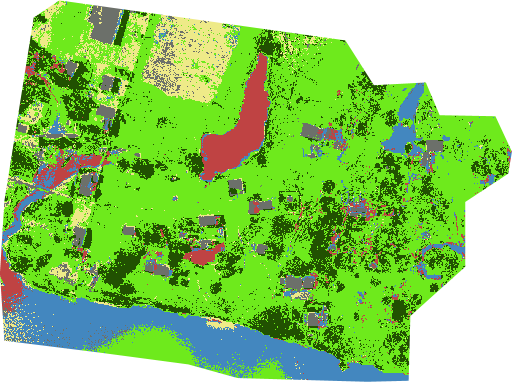

In [7]:
seed = 2000
polygons1 = polygons.randomColumn('random',seed);
regionsOfInterest1 = image.select(bands).sampleRegions(polygons1,['class', 'random'],2)
fullClassifier1 = classifier.train(regionsOfInterest1, 'class', bands)
image_app2 = image.classify(fullClassifier1)
image_class= image_app2.visualize(**{'min':0, 'max':5, 'palette':'EEEA88, 6eea1c, 215101, bf4343, 6c706a,4387bf'}) 
url = image_class.getThumbUrl({'region':geometry.geometries().get(2).getInfo()})
Image(url=url, embed=True, format='png')

In [8]:
mancioLima = ee.Geometry(geometry.geometries().get(4))
salvador = ee.Geometry(geometry.geometries().get(2))
urcoMirano = ee.Geometry(geometry.geometries().get(0)).union(ee.Geometry(geometry.geometries().get(5))).union(ee.Geometry(geometry.geometries().get(7)))
libertad = ee.Geometry(geometry.geometries().get(3)).union(ee.Geometry(geometry.geometries().get(6)))
vistoBueno = ee.Geometry(geometry.geometries().get(1))

In [9]:
communities = ee.List([mancioLima, salvador, urcoMirano, libertad, vistoBueno])

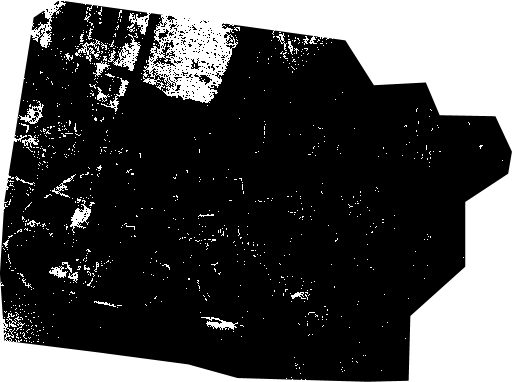

In [10]:
image_class= image_app2.eq(0)
url = image_class.getThumbUrl({'region':geometry.geometries().get(2).getInfo()})
Image(url=url, embed=True, format='png')

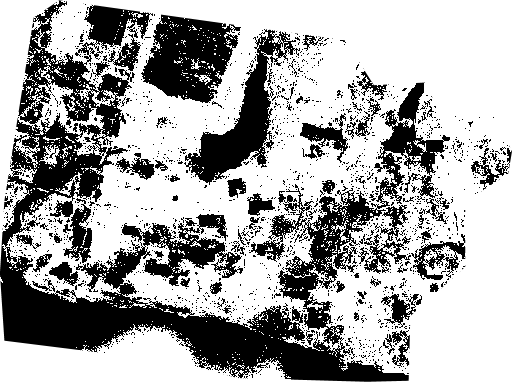

In [11]:
image_class= image_app2.eq(1)
url = image_class.getThumbUrl({'region':geometry.geometries().get(2).getInfo()})
Image(url=url, embed=True, format='png')

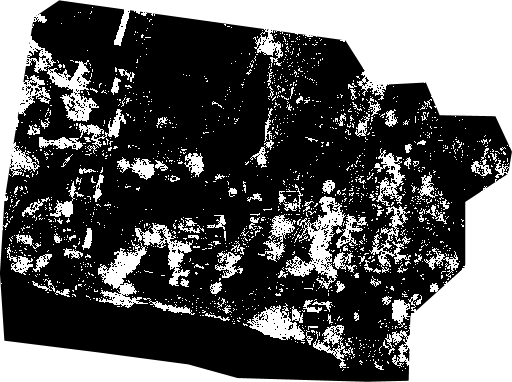

In [12]:
image_class= image_app2.eq(2)
url = image_class.getThumbUrl({'region':geometry.geometries().get(2).getInfo()})
Image(url=url, embed=True, format='png')

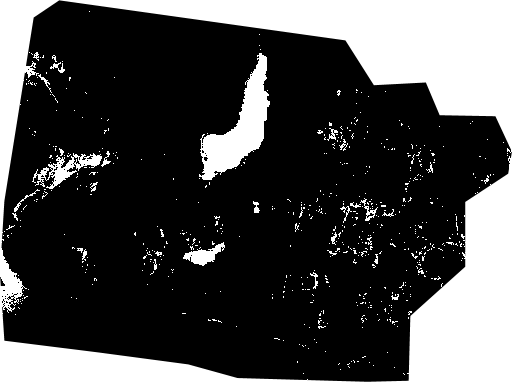

In [13]:
image_class= image_app2.eq(3)
url = image_class.getThumbUrl({'region':geometry.geometries().get(2).getInfo()})
Image(url=url, embed=True, format='png')

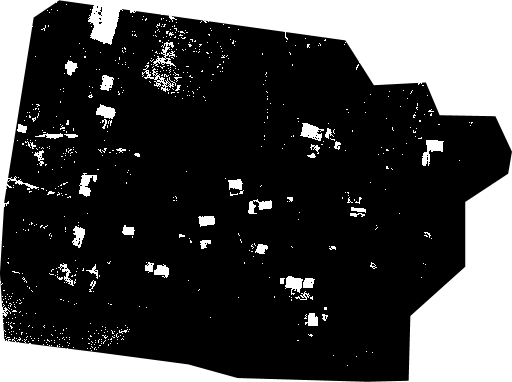

In [14]:
image_class= image_app2.eq(4)
url = image_class.getThumbUrl({'region':geometry.geometries().get(2).getInfo()})
Image(url=url, embed=True, format='png')

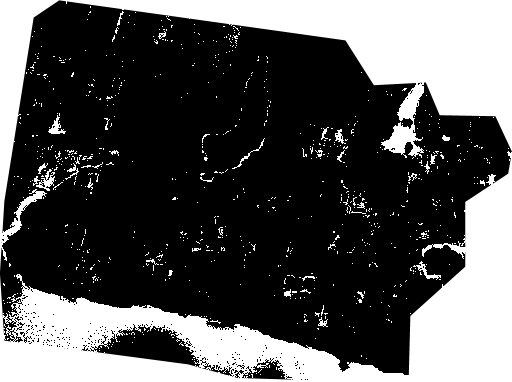

In [15]:
image_class= image_app2.eq(5)
url = image_class.getThumbUrl({'region':geometry.geometries().get(2).getInfo()})
Image(url=url, embed=True, format='png')

In [16]:
def get_count(image, clase, geometry):
    count = image.eq(clase).gt(0).reduceRegion(reducer = ee.Reducer.sum(), geometry = geometry, scale = 0.02, bestEffort = True)
    return count.toArray().getInfo()

In [21]:
salvador = {}
clase = 0
while clase < 6:
    print clase
    key = clase
    value = get_count(image_app2, clase, communities.get(1))
    salvador[key] = np.mean(value)
    clase += 1
df_salvador = pd.DataFrame(salvador.items(), columns = ['class', 'count'])
print df_salvador

salvador_prop = pd.DataFrame(index = range(6), columns = ['Salvador'])
i = 0
while i < 6:
    salvador_prop['Salvador'][i]=df_salvador['count'][i]/df_salvador['count'].sum()
    i += 1
print salvador_prop

0
1
2
3
4
5
   class         count
0      0  5.940351e+05
1      1  5.198986e+06
2      2  1.811604e+06
3      3  6.129248e+05
4      4  5.007467e+05
5      5  1.273540e+06
    Salvador
0   0.059452
1   0.520323
2   0.181308
3  0.0613426
4  0.0501156
5   0.127458


In [22]:
libertad = {}
clase = 0
while clase < 6:
    print clase
    key = clase
    value = get_count(image_app2, clase, communities.get(3))
    libertad[key] = np.mean(value)
    clase += 1
df_libertad = pd.DataFrame(libertad.items(), columns = ['class', 'count'])
print df_libertad

libertad_prop = pd.DataFrame(index = range(6), columns = ['Libertad'])
i = 0
while i < 6:
    libertad_prop['Libertad'][i]=df_libertad['count'][i]/df_libertad['count'].sum()
    i += 1
print libertad_prop


0
1
2
3
4
5
   class         count
0      0  4.442780e+05
1      1  2.409004e+06
2      2  3.486108e+06
3      3  1.693989e+06
4      4  3.743816e+05
5      5  1.586191e+06
    Libertad
0  0.0444547
1   0.241046
2   0.348822
3   0.169501
4  0.0374608
5   0.158715


In [23]:
urcoMirano = {}
clase = 0
while clase < 6:
    print clase
    key = clase
    value = get_count(image_app2, clase, communities.get(2))
    urcoMirano[key] = np.mean(value)
    clase += 1
df_urcoMirano = pd.DataFrame(urcoMirano.items(), columns = ['class', 'count'])
print df_urcoMirano

urcoMirano_prop = pd.DataFrame(index = range(6), columns = ['UrcoMirano'])
i = 0
while i < 6:
    urcoMirano_prop['UrcoMirano'][i]=df_urcoMirano['count'][i]/df_urcoMirano['count'].sum()
    i += 1
print urcoMirano_prop

0
1
2
3
4
5
   class         count
0      0  2.236886e+05
1      1  3.759611e+06
2      2  5.169591e+06
3      3  5.897159e+04
4      4  4.989925e+05
5      5  2.891909e+05
   UrcoMirano
0   0.0223688
1    0.375959
2    0.516957
3  0.00589713
4    0.049899
5    0.028919


In [24]:
vistoBueno = {}
clase = 0
while clase < 6:
    print clase
    key = clase
    value = get_count(image_app2, clase, communities.get(4))
    vistoBueno[key] = np.mean(value)
    clase += 1
df_vistoBueno = pd.DataFrame(vistoBueno.items(), columns = ['class', 'count'])
print df_vistoBueno

vistoBueno_prop = pd.DataFrame(index = range(6), columns = ['VistoBueno'])
i = 0
while i < 6:
    vistoBueno_prop['VistoBueno'][i]=df_vistoBueno['count'][i]/df_vistoBueno['count'].sum()
    i += 1
print vistoBueno_prop

0
1
2
3
4
5
   class         count
0      0  5.508533e+05
1      1  3.492505e+06
2      2  4.986049e+06
3      3  2.597684e+05
4      4  4.658286e+05
5      5  2.450020e+05
  VistoBueno
0  0.0550853
1    0.34925
2   0.498605
3  0.0259768
4  0.0465828
5  0.0245002


In [25]:
df_communities = pd.concat([vistoBueno_prop, libertad_prop], axis=1)
df_communities = pd.concat([df_communities, urcoMirano_prop], axis=1)
df_communities = pd.concat([df_communities, salvador_prop], axis=1)
df_communities['class'] = ['Bare soil','Low vegetation','High vegetation','Positive to An. darlingi','Urban', 'Negative to An. darlingi']
df_communities

,VistoBueno,Libertad,UrcoMirano,Salvador,class
0,0.0550853,0.0444547,0.0223688,0.059452,Bare soil
1,0.34925,0.241046,0.375959,0.520323,Low vegetation
2,0.498605,0.348822,0.516957,0.181308,High vegetation
3,0.0259768,0.169501,0.00589713,0.0613426,Positive to An. darlingi
4,0.0465828,0.0374608,0.049899,0.0501156,Urban
5,0.0245002,0.158715,0.028919,0.127458,Negative to An. darlingi


In [26]:
df_long = pd.melt(df_communities, id_vars=['class'], var_name='communities')
df_long

,class,communities,value
0,Bare soil,VistoBueno,0.0550853
1,Low vegetation,VistoBueno,0.34925
2,High vegetation,VistoBueno,0.498605
3,Positive to An. darlingi,VistoBueno,0.0259768
4,Urban,VistoBueno,0.0465828
5,Negative to An. darlingi,VistoBueno,0.0245002
6,Bare soil,Libertad,0.0444547
7,Low vegetation,Libertad,0.241046
8,High vegetation,Libertad,0.348822
9,Positive to An. darlingi,Libertad,0.169501


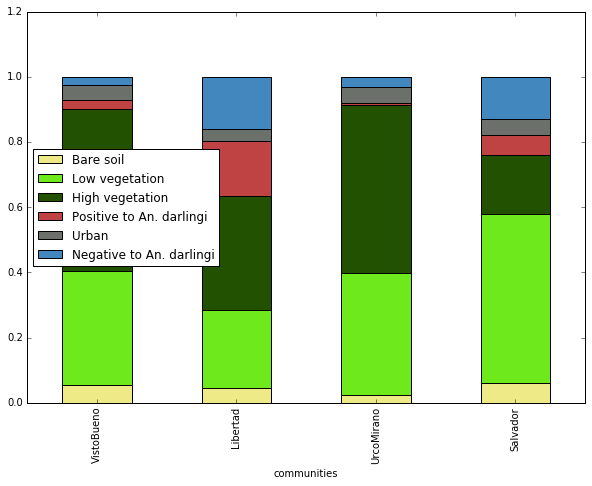

In [27]:
fig, ax = plt.subplots(figsize=(10,7))  

classes = df_long['class'].drop_duplicates()
margin_bottom = np.zeros(len(df_long['communities'].drop_duplicates()))
colors = ['#EEEA88', '#6eea1c', '#215101', '#bf4343', '#6c706a','#4387bf']

for num, classf in enumerate(classes):
    values = list(df_long[df_long['class'] == classf].loc[:, 'value'])

    df_long[df_long['class'] == classf].plot.bar(x='communities',y='value', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=colors[num], label=classf)
    margin_bottom += values

plt.show()
